In [1]:
import sys
import os
import numpy as np
import plg_tasks
import tensorflow as tf
import matplotlib.pyplot as plt
import motornet as mn
from motornet.plants.muscles import RigidTendonHillMuscleThelen

%load_ext autoreload
%autoreload 2

# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

print(mn.__version__)

0.1.2


In [23]:

def create_network():
    # SET UP PLANT
    plant = mn.plants.RigidTendonArm26(muscle_type=RigidTendonHillMuscleThelen(), visual_delay=0.07, proprioceptive_delay=0.02)
    # SET UP NETWORK
    n_units = 64
    network = mn.nets.layers.GRUNetwork(plant=plant, n_units=n_units, kernel_regularizer=1e-7, name='network', recurrent_regularizer=1e-5)
    # SET UP TASK
    start_position = [0.785, 1.570] # [45,90] deg
    go_cue_range = (.100, .300)
    task = plg_tasks.CentreOutFF(network=network, start_position=start_position, go_cue_range=go_cue_range)
    task.network.do_recompute_inputs = True
    task.network.recompute_inputs = task.recompute_inputs
    # SET UP RNN
    rnn = tf.keras.layers.RNN(cell=network, return_sequences=True, name='RNN')
    input_dict = task.get_input_dict_layers()
    state0 = task.get_initial_state_layers()
    states_out = rnn(input_dict, initial_state=state0)
    # SET UP MAIN NETWORK OBJECT
    nn = mn.nets.MotorNetModel(inputs=[input_dict, state0], outputs=states_out, name='model', task=task)
    nn.compile(optimizer=tf.optimizers.Adam(clipnorm=1.), loss=task.losses, loss_weights=task.loss_weights)
    return nn



In [39]:

nn = create_network()
nn.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ff_coefficient (InputLayer)    [(None, None, 1)]    0           []                               
                                                                                                  
 inputs (InputLayer)            [(None, None, 5)]    0           []                               
                                                                                                  
 joint0 (InputLayer)            [(None, 4)]          0           []                               
                                                                                                  
 cartesian0 (InputLayer)        [(None, 4)]          0           []                               
                                                                                              

# LOAD NETWORK TRAINED IN NULL FIELD

In [40]:
weight_file = "save" + os.path.sep + "null" + os.path.sep + "null" + "_" + "weights"
nn.load_weights(weight_file).expect_partial()

In [35]:
def hand_to_joints(xy, L1, L2):
      j = np.zeros(np.shape(xy))
      j[:,:,1] = np.arccos((xy[:,:,0]**2 + xy[:,:,1]**2 - L1**2 - L2**2) / (2*L1*L2))
      j[:,:,0] = np.arctan2(xy[:,:,1],xy[:,:,0]) - np.arctan2(L2*np.sin(j[:,:,1]),L1+(L2*np.cos(j[:,:,1])))
      return j

def plot_simulations(xy, target_xy):
  target_x = target_xy[:, -1, 0]
  target_y = target_xy[:, -1, 1]
  plt.figure()
  nmov,ntime,_ = np.shape(xy)
  for i in range(nmov):
        plt.plot(xy[i,:,0],xy[i,:,1],color="b",linewidth=1.0)
  plt.scatter(target_x, target_y)
  plt.axis("equal")
  plt.xlabel("X (m)")
  plt.ylabel("Y (m)")
  plt.show()

def plot1trial(inputs, results, targets_j, trial=0):
    j_results = results['joint position']
    m_results = results['muscle state']

    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0]*180/np.pi, label='sho')
    plt.plot(j_results[trial, :, 1]*180/np.pi, label='elb')
    plt.plot(targets_j[trial, :, 0]*180/np.pi, '--')
    plt.plot(targets_j[trial, :, 1]*180/np.pi, '--')
    plt.axvline(np.where(inputs["inputs"][trial, :, -1] != 1)[0][0] - nn.task.network.visual_delay, c='grey')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (deg)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2], label='sho')
    plt.plot(j_results[trial, :, 3], label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :])
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.subplot(144)
    plt.plot(m_results[trial, :, -1, :])
    plt.xlabel('time (ms)')
    plt.ylabel('force (N)')
    plt.legend(["PEC","DEL","BRA","TRI","BIC","TR2"], loc=1)

    plt.show()



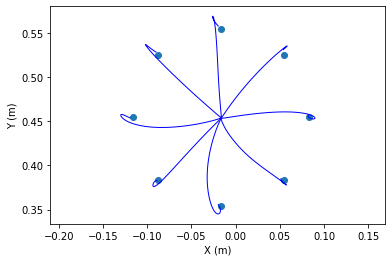

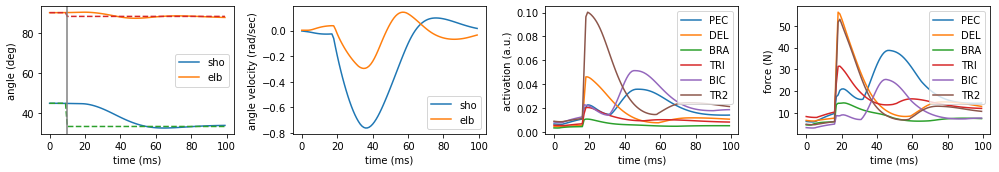

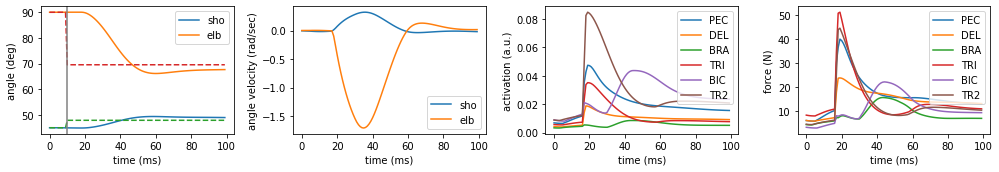

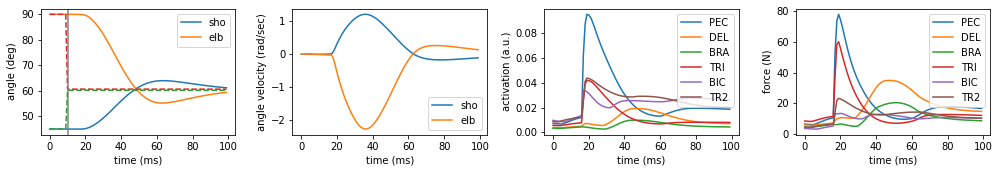

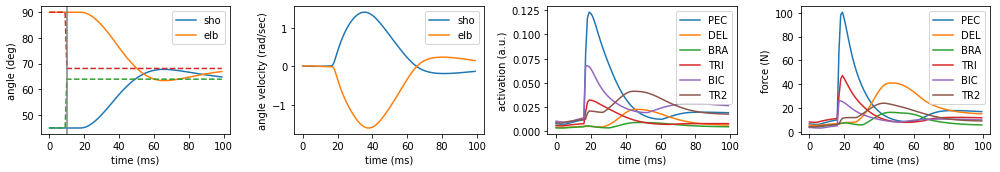

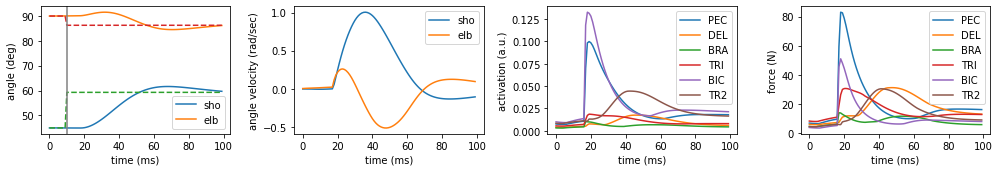

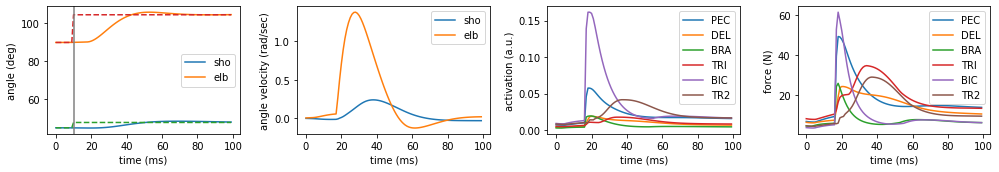

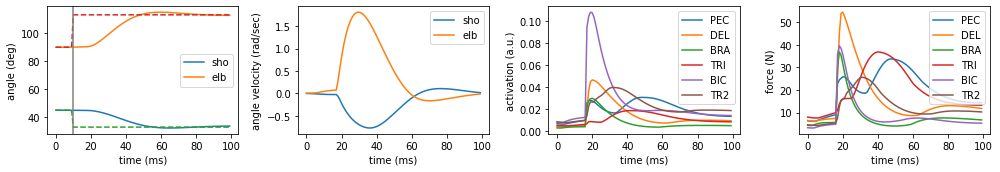

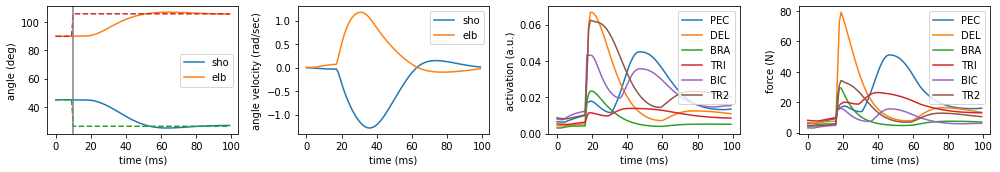

In [41]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A NULL FIELD


condition = "test"

n_mov_circle = 8 # number of movement directions around the unit circle

n_t = 100
nn.task.angular_step = 360 / n_mov_circle
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_mov_circle, condition=condition)
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

# Make some plots of EMG and of hidden unit activity

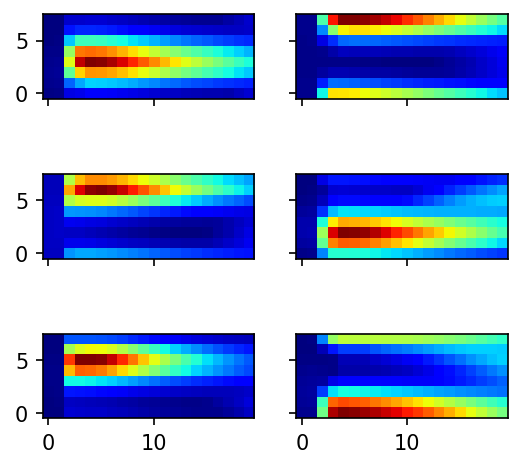

In [42]:
def get_angle(xx, yy):
    return np.mod(np.arctan2(yy, xx) + 2*np.pi, 2*np.pi)

def sort_data(results, dataset):
    # make start position [0, 0]
    xx = targets[:,-1,0] - targets[:,0,0]
    yy = targets[:,-1,1] - targets[:,0,1]
    angles = get_angle(xx, yy)
    ang_index = np.argsort(angles)
    sorted_data = results[ang_index,:,:]
    return sorted_data

data = {"results":results, "inputs":inputs, "targets":targets}
muscle_activations = data['results']["muscle state"][:, :, 0, :].numpy()
im = sort_data(muscle_activations, data)

n_muscles = im.shape[2]

fig, axs = plt.subplots(3, 2, sharex='all', sharey='all',figsize=(4,4), dpi=150)
axs = axs.reshape(-1)
for n in range(n_muscles):
  axs[n].imshow(im[:, 15:35, n], cmap='jet')
axs[0].invert_yaxis()


# TEST NULL NETWORK ON CURL FIELD

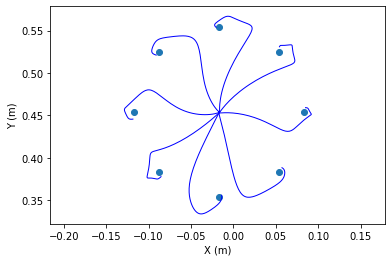

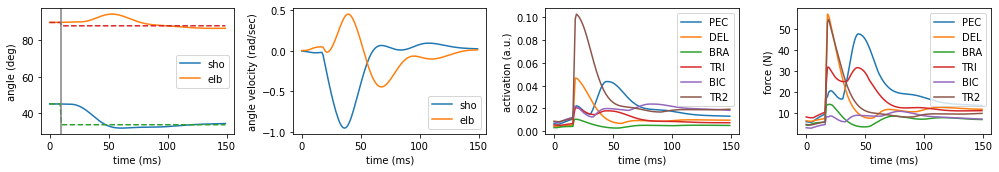

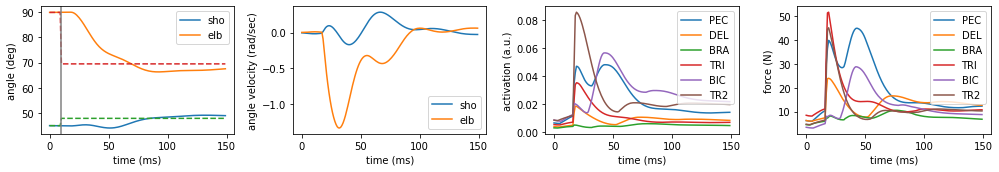

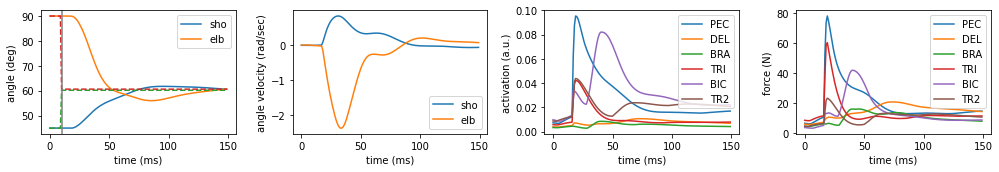

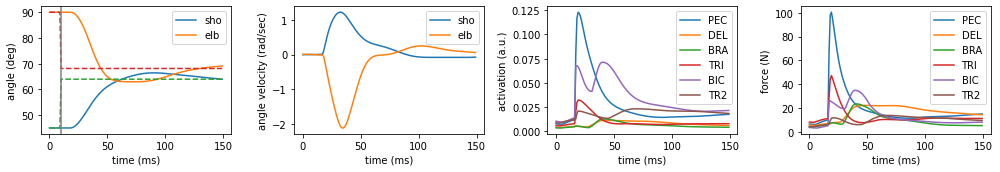

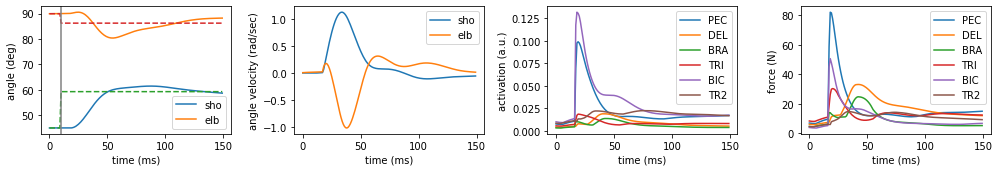

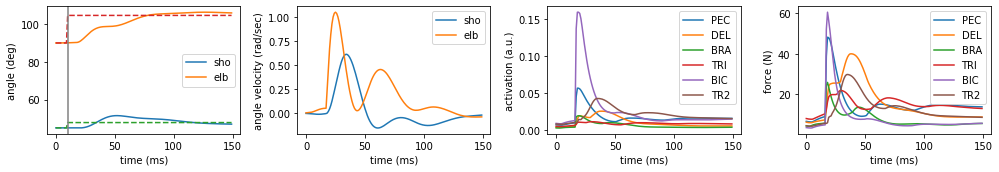

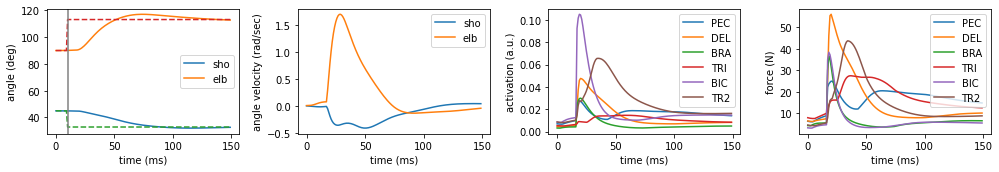

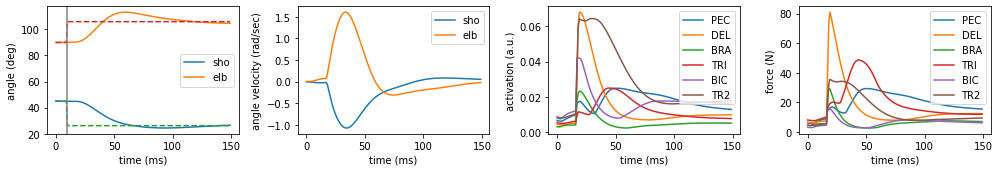

In [43]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A CCW CURL FIELD


condition = "test"

n_mov_circle = 8

n_t = 150
nn.task.angular_step = 360 / n_mov_circle
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_mov_circle, condition=condition, ff_coefficient=8)
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

# TRAIN NETWORK on centre-out reaches


In [45]:
# IN A CCW FF

condition = "adapt"

n_t = 100
n_batches = 256
batch_size = 64
# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger()]
for i in range(1):
    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=batch_size*n_batches, condition=condition, ff_coefficient=8)
    h = nn.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)

256/256 [==============================] - 53s 205ms/step - loss: 0.0197 - position_loss: 0.0081 - gru_regularizer_loss: 0.0090 - l2_xdx_activation_loss: 3.2775e-04


In [14]:

# save model weights
weight_file = "save" + os.path.sep + "adapted" + os.path.sep + "adapted" + "_" + "weights"
nn.save_weights(weight_file)


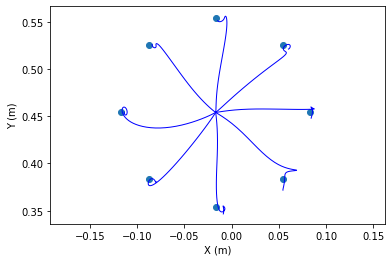

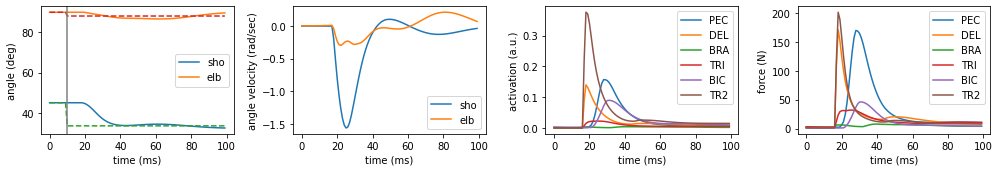

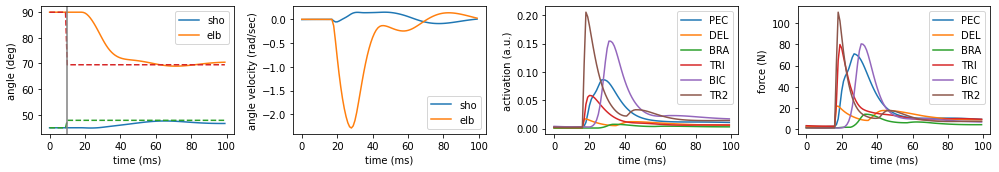

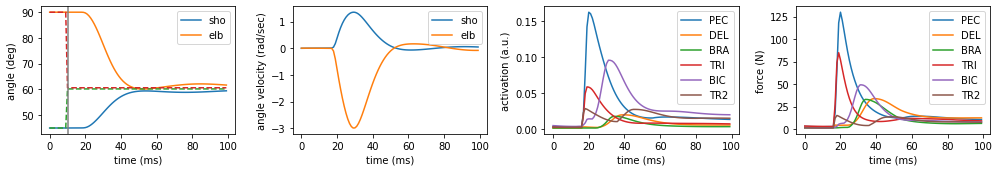

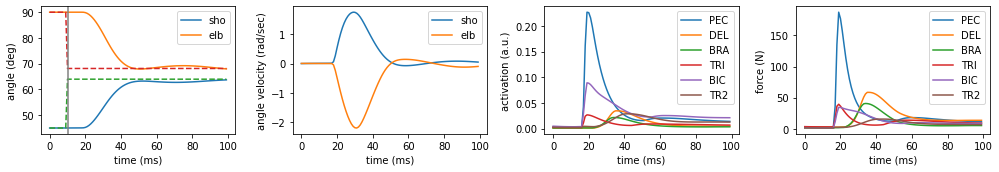

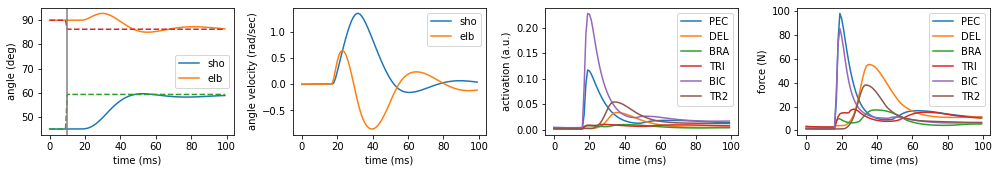

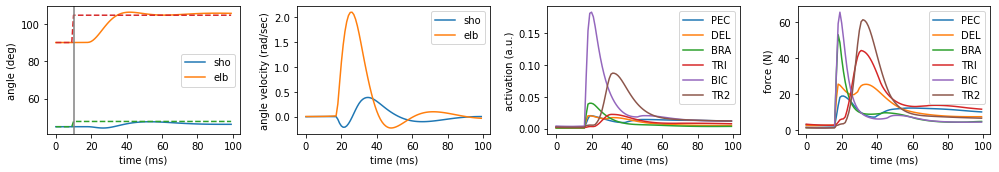

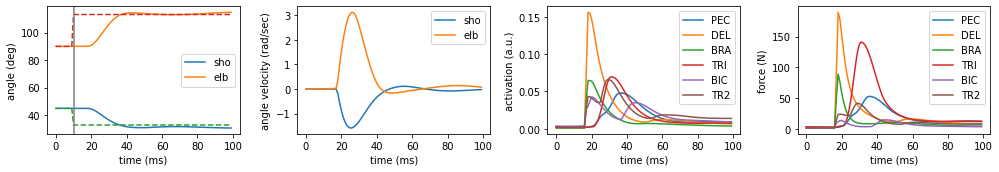

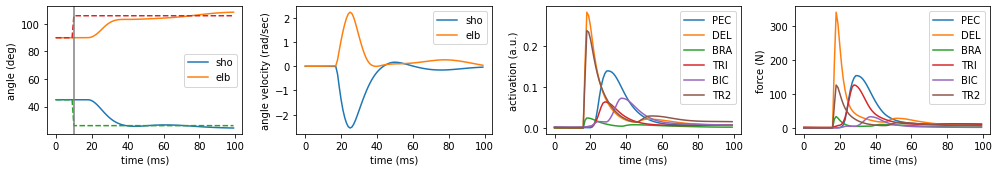

In [46]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A CCW CURL FIELD

condition = "test"

n_mov_circle = 8

n_t = 100
nn.task.angular_step = 360 / n_mov_circle
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_mov_circle, condition=condition, ff_coefficient=8)
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

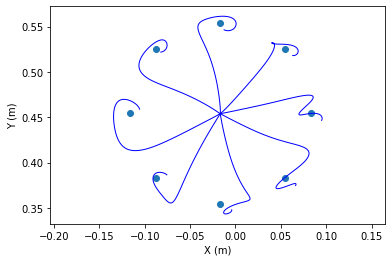

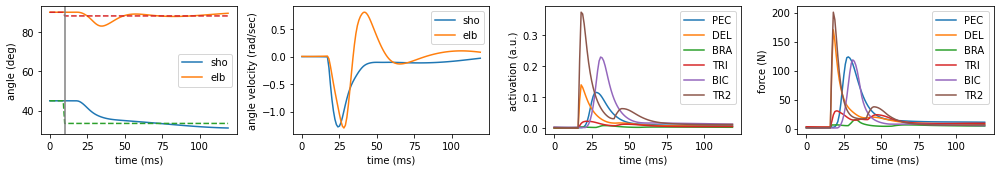

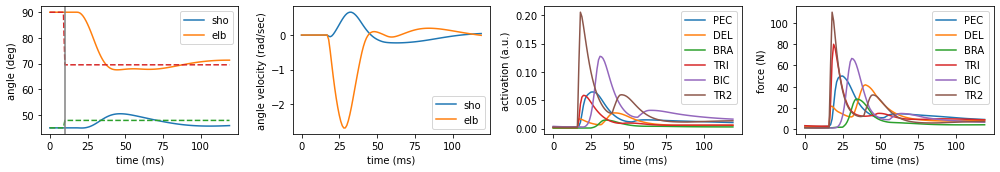

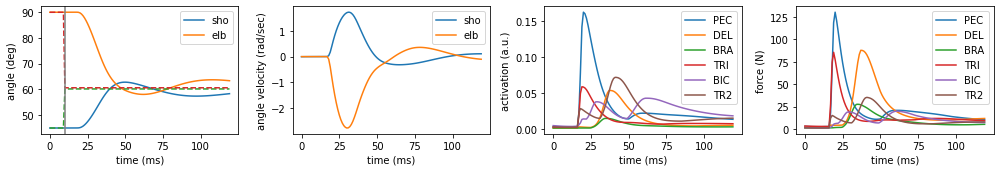

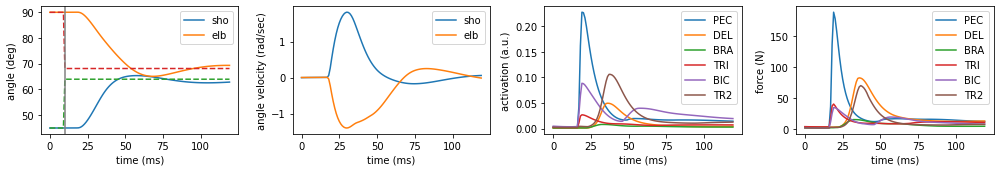

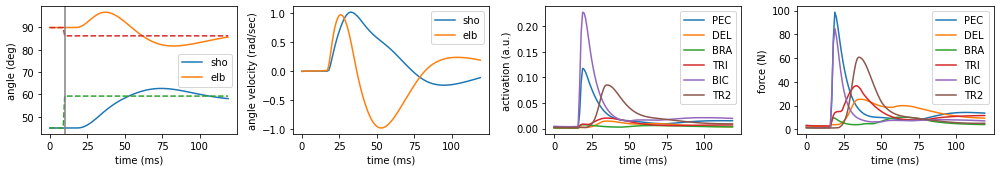

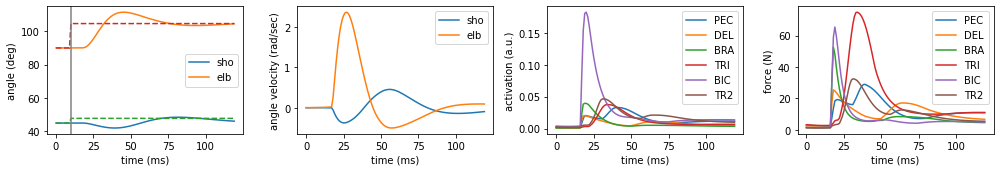

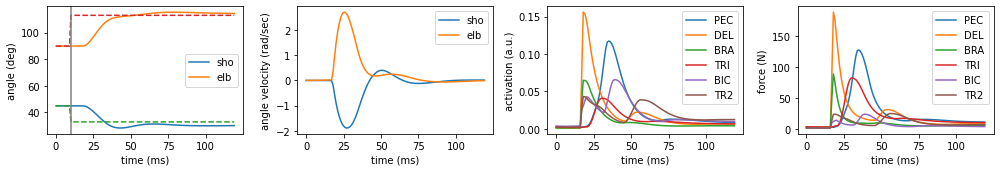

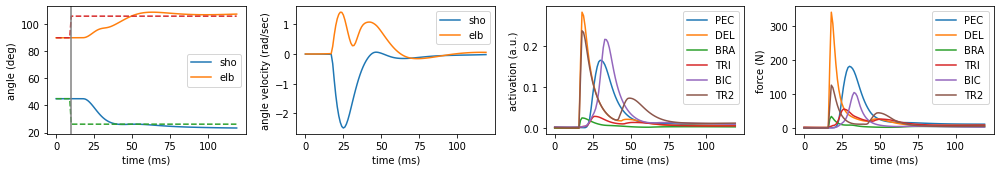

In [47]:
# TEST THE NETWORK ON THE CENTRE-OUT REACHING TASK
# IN A NULL FIELD

condition = "test"

n_mov_circle = 8

n_t = 120
nn.task.angular_step = 360 / n_mov_circle
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_mov_circle, condition=condition, ff_coefficient=0)
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

In [48]:



condition = "adapt"

n_t = 100
n_batches = 256
batch_size = 64
# this callback logs training information for each batch passed, rather than for each epoch.
callbacks = [mn.nets.callbacks.BatchLogger()]
for i in range(1):
    [inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=batch_size*n_batches, condition=condition, ff_coefficient=0)
    h = nn.fit(x=[inputs, init_states], y=targets, verbose=1, epochs=1, batch_size=batch_size, shuffle=False, callbacks=callbacks)


256/256 [==============================] - 53s 208ms/step - loss: 0.0188 - position_loss: 0.0077 - gru_regularizer_loss: 0.0093 - l2_xdx_activation_loss: 3.0180e-04


# Washout

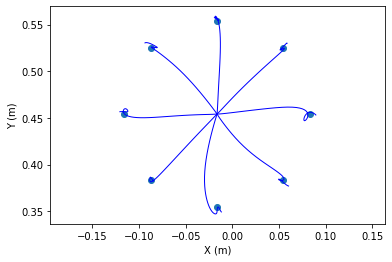

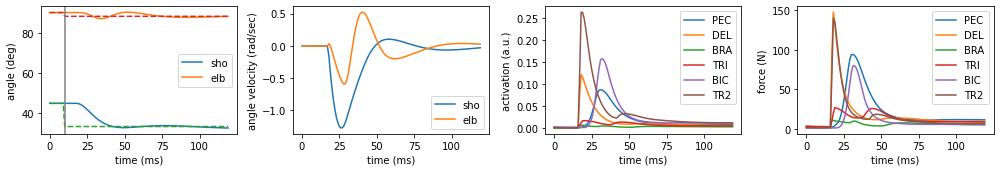

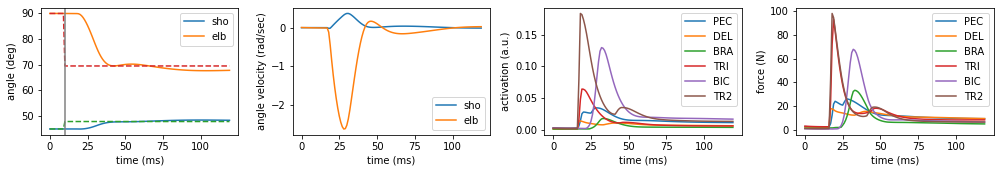

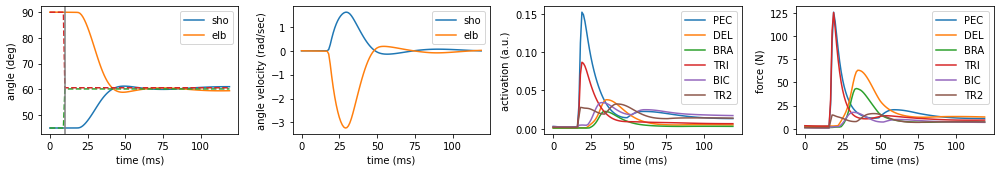

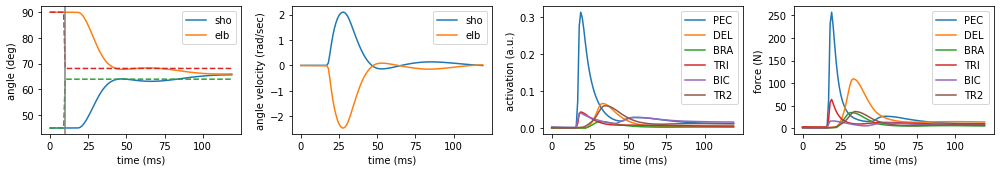

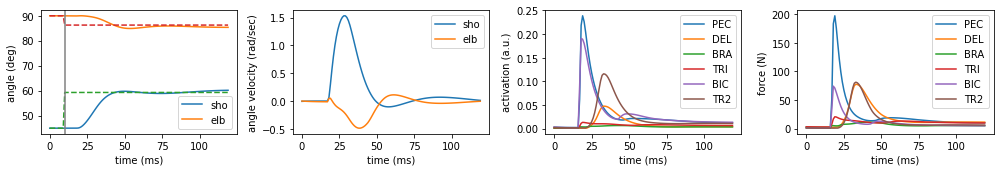

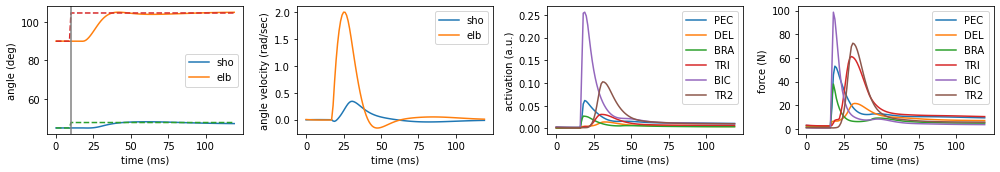

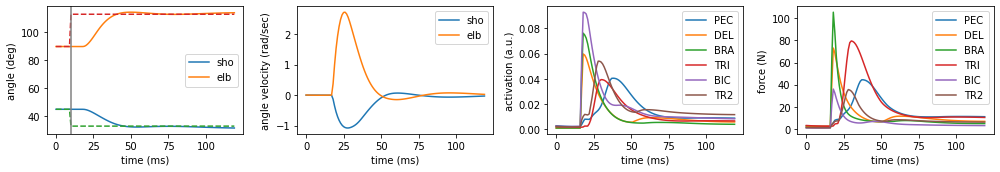

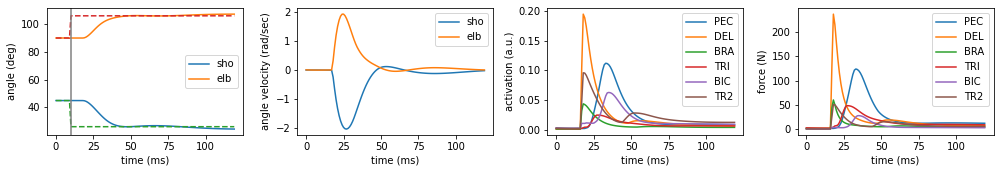

In [49]:
condition = "test"

n_mov_circle = 8

n_t = 120
nn.task.angular_step = 360 / n_mov_circle
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_mov_circle, condition=condition, ff_coefficient=0)
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)

# Test in CF after washout

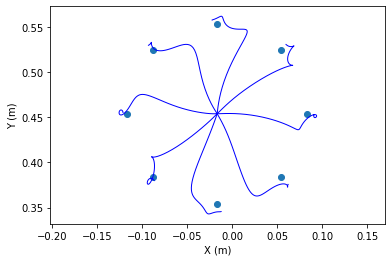

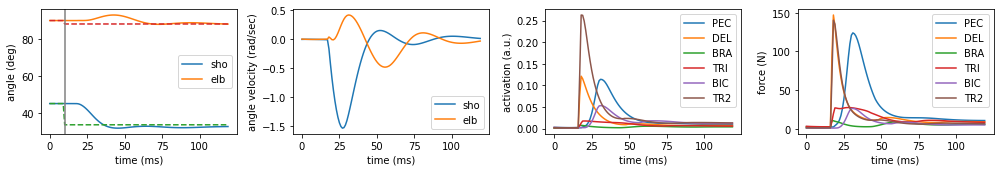

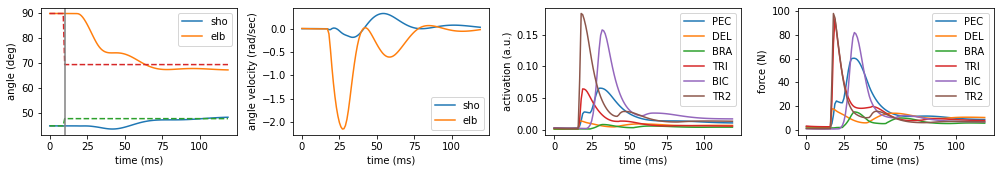

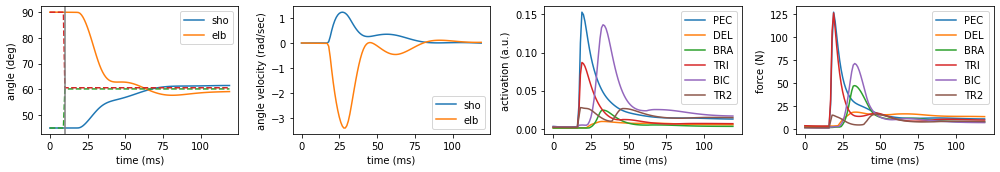

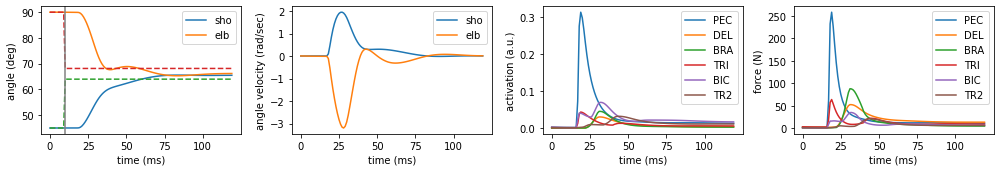

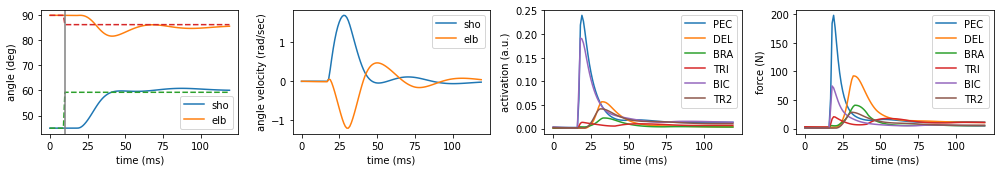

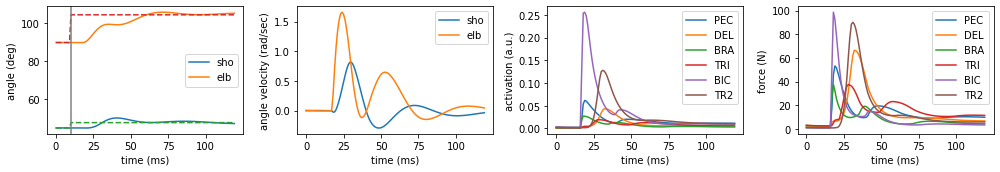

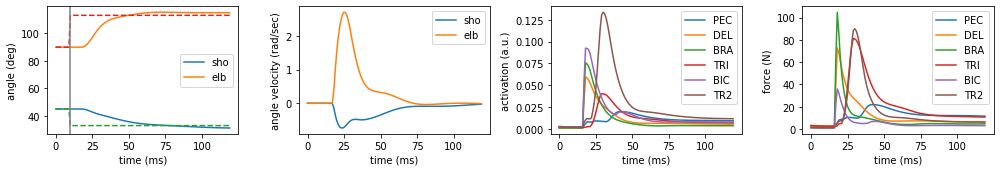

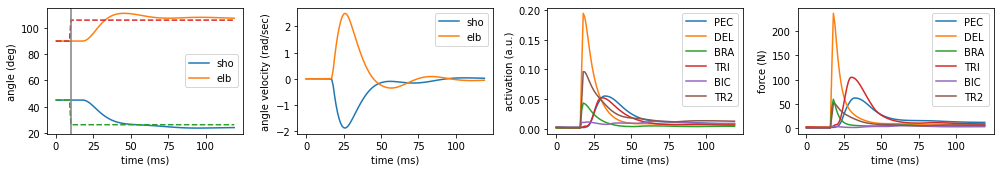

In [50]:
condition = "test"

n_mov_circle = 8

n_t = 120
nn.task.angular_step = 360 / n_mov_circle
[inputs, targets, init_states] = nn.task.generate(n_timesteps=n_t, batch_size=n_mov_circle, condition=condition, ff_coefficient=8)
results = nn([inputs, init_states], training=False)

plot_simulations(xy=results["cartesian position"], target_xy=targets)

L1,L2 = nn.task.network.plant.skeleton.L1, nn.task.network.plant.skeleton.L2
targets_j = hand_to_joints(targets, L1, L2)
n_mov = np.shape(results["joint position"])[0]
for i in range(n_mov):
    plot1trial(inputs, results, targets_j, i)